<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [4]:
import os

os.chdir('/root/dev/gen_assignment/DeepGenerativeModels')
os.getcwd()

'/root/dev/gen_assignment/DeepGenerativeModels'

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw4_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw4_data.zip -d deepul/homeworks/hw4/data
!rm hw4_data.zip

--2023-05-22 20:43:08--  https://docs.google.com/uc?export=download&confirm=t&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 142.251.220.14, 2404:6800:4005:809::200e
Connecting to docs.google.com (docs.google.com)|142.251.220.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j0v5h803fadsisvdv1bncqk0sardelhs/1684755750000/06419056966375271799/*/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download&uuid=fc2bd530-5c29-4a42-b4c4-1eccfbaa30fb [following]
--2023-05-22 20:43:08--  https://doc-08-48-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j0v5h803fadsisvdv1bncqk0sardelhs/1684755750000/06419056966375271799/*/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download&uuid=fc2bd530-5c29-4a42-b4c4-1eccfbaa30fb
Resolving doc-08-48-docs.googleusercontent.com (doc-08-48-docs.googleusercontent.com)... 142.250.207.65, 2404:6800:4

In [5]:
from deepul.hw4_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [6]:
ptu.set_gpu_mode(True)
ptu.device

device(type='cuda', index=0)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm

# Question 1: Warmup [20pt]

In this question, we will train 2 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

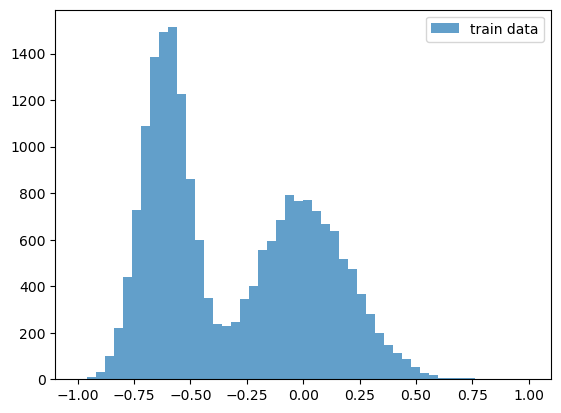

In [5]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



### Solution

In [7]:
def train(generator, critic, c_loss_fn, g_loss_fn, train_loader, g_optimizer, c_optimizer, n_critic=1, g_scheduler=None, c_scheduler=None, weight_clipping=None):
    """
    generator: 
    critic: discriminator in 1ab, general model otherwise
    loss_fn
    train_loader: instance of DataLoader class
    optimizer: 
    ncritic: how many critic gradient steps to do for every generator step
    """
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        x = x.to(ptu.device).float()
        c_loss = c_loss_fn(generator, critic, x)
        c_optimizer.zero_grad()
        c_loss.backward()
        c_optimizer.step()
        c_losses.append(c_loss.item())
        if weight_clipping is not None:
            for param in critic.parameters():
                param.data.clamp_(-weight_clipping, weight_clipping)

        if i % n_critic == 0:  # generator step
            g_loss = g_loss_fn(generator, critic, x)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)

def train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    if 'optim_cls' in train_args:
        g_optimizer = train_args['optim_cls'](generator.parameters(), lr=lr)
        c_optimizer = train_args['optim_cls'](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))
        
    if train_args.get('lr_schedule', None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(g_optimizer, train_args['lr_schedule'])
        c_scheduler = optim.lr_scheduler.LambdaLR(c_optimizer, train_args['lr_schedule'])
    else:
        g_scheduler = None
        c_scheduler = None 

    train_losses = dict()
    for epoch in range(epochs):
        if epoch == 1:
            epoch1_snapshot = get_training_snapshot(generator, critic)
        generator.train()
        critic.train()
        train_loss = train(generator, critic, c_loss_fn, g_loss_fn, train_loader, 
                           g_optimizer, c_optimizer, n_critic=train_args.get('n_critic', 0), 
                           g_scheduler=g_scheduler, c_scheduler=c_scheduler,
                           weight_clipping=train_args.get('weight_clipping', None))
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get('q1', False):  # q1, return the snapshots
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *epoch1_snapshot, *final_snapshot]
    else:
        return train_losses

def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-1, 1, 1000)
    samples = ptu.get_numpy(generator.sample(n_samples))
    critic_output = ptu.get_numpy(critic(ptu.FloatTensor(xs).unsqueeze(1)))
    return samples, xs, critic_output
     

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        layers = []
        self.latent_dim = latent_dim
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
        # self.log_scale = nn.Parameter(torch.zeros(data_dim), requires_grad=True)
    
    def forward(self, z):
        return torch.tanh(self.mlp(z)) # * self.log_scale.exp()
        return self.mlp(z) # * self.log_scale.exp()
        
    def sample(self, n):
        # n is the number of samples to return
        z = ptu.normal(ptu.zeros(n, self.latent_dim), ptu.ones(n, self.latent_dim))
        return self.forward(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
    
    def forward(self, z):
        return torch.sigmoid(self.mlp(z)) 

In [9]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return (1 - critic(fake_data)).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final

### Results

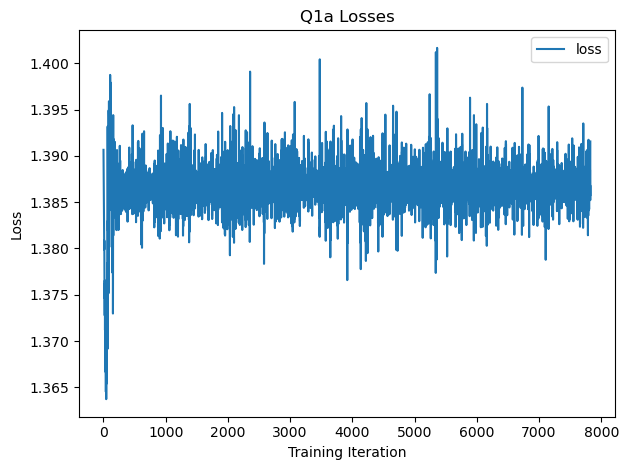

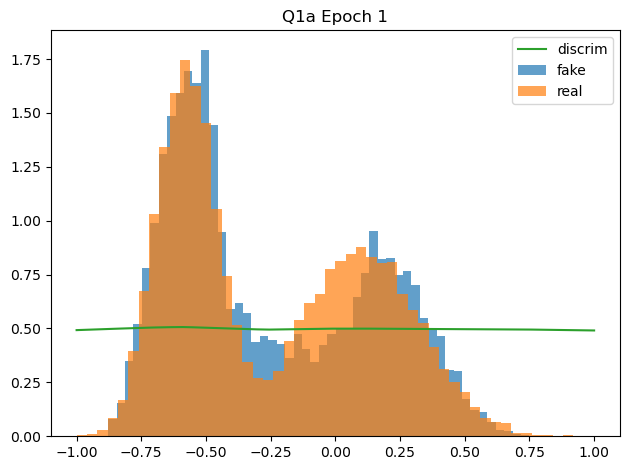

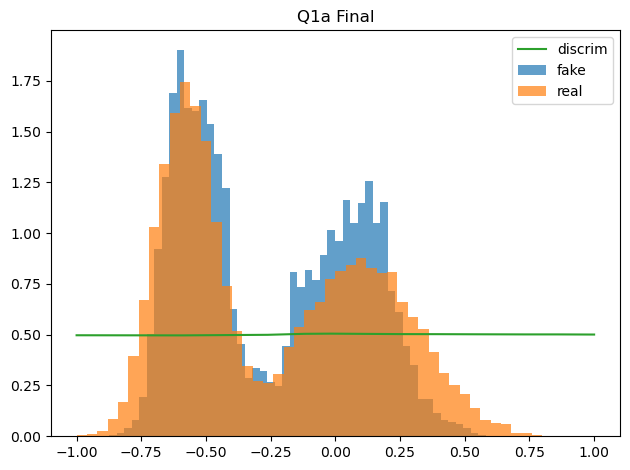

In [10]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [11]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    # create data loaders
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    # model
    g = MLPGenerator(1, 3, 128, 1).to(ptu.device)
    c = MLPDiscriminator(1, 3, 128, 1).to(ptu.device)

    # loss functions
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return  - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()

    # train
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = train_epochs(g, c, g_loss, c_loss, train_loader, dict(epochs=25, lr=1e-4, n_critic=2, q1=True))

    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final

 ### Results

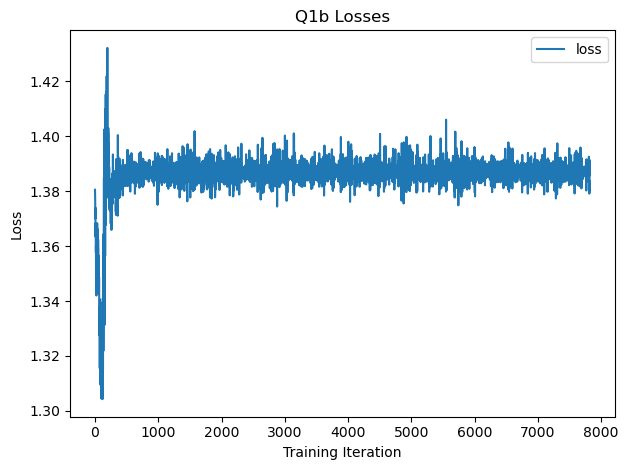

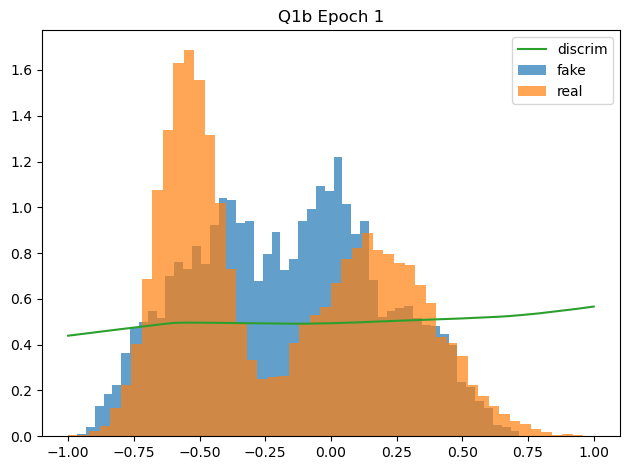

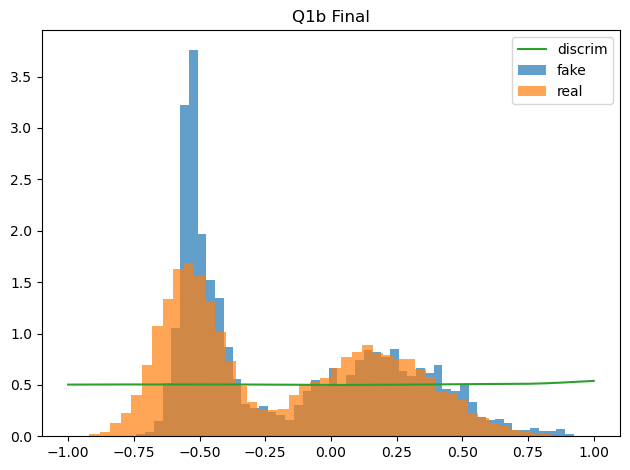

In [12]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


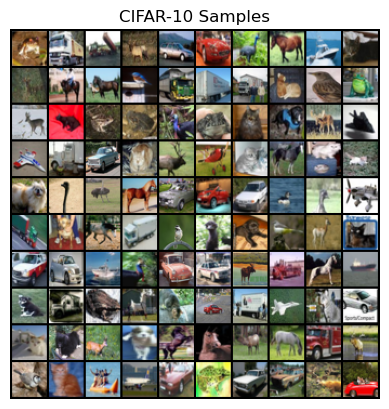

In [10]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

In [24]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super(Upsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, x):
        _x = torch.cat([x, x, x, x], dim=1)
        _x = self.depth_to_space(_x)
        _x = self.conv(_x)
        return _x


class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1, bias=True):
        super(Downsample_Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.space_to_depth = SpaceToDepth(2)

    def forward(self, x):
        _x = self.space_to_depth(x)
        _x = sum(_x.chunk(4, dim=1)) / 4.0
        _x = self.conv(_x)
        return _x


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlockUp, self).__init__()
        self.layers = nn.ModuleList([
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1),
            Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        ])

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), stride=1, n_filters=256):
        super(ResnetBlockDown, self).__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, stride=stride, padding=1),
            nn.ReLU(),
            Downsample_Conv2d(n_filters, n_filters, kernel_size),
            Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        ])

    def forward(self, x):
        _x = x
        for i in range(len(self.layers) - 1):
            _x = self.layers[i](_x)
        return self.layers[-1](x) + _x


class ResBlock(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResBlock, self).__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, padding=1)
        ])

    def forward(self, x):
        _x = x
        for op in self.layers:
            _x = op(_x)
        return x + _x


class Generator(nn.Module):
    def __init__(self, n_filters=256):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        ]
        self.net = nn.Sequential(*network)
        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

    def forward(self, z):
        z = self.fc(z).reshape(-1, 256, 4, 4)
        return self.net(z)

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).to(ptu.device)
        return self.forward(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(128, 4 * 4 * 256)
        network = [
            ResnetBlockDown(3, n_filters=128),
            ResnetBlockDown(128, n_filters=128),
            ResBlock(128, n_filters=128),
            ResBlock(128, n_filters=128),
            nn.ReLU()
        ]
        self.net = nn.Sequential(*network)
        self.fc = nn.Linear(128, 1)

    def forward(self, z):
        z = self.net(z)
        z = torch.sum(z, dim=(2, 3))
        return self.fc(z)

In [96]:
class Solver(object):
    def __init__(self, train_data, n_iterations=50000, batch_size=256, n_filters=128):
        self.n_critic = 5
        self.log_interval = 100
        self.batch_size = batch_size
        self.n_filters = n_filters
        self.train_loader = self.create_loaders(train_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = 40
        print("total number of epochs: ", self.n_epochs)
        self.curr_itr = 0

    def build(self, part_name):
        self.g = Generator(n_filters=self.n_filters).to(ptu.device)
        self.d = Discriminator().to(ptu.device)
        self.g_optimizer = torch.optim.Adam(self.g.parameters(), lr=2e-4, betas=(0, 0.9))
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0, 0.9))
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(self.d_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.part_name = part_name

    def create_loaders(self, train_data):
        train_loader = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def gradient_penalty(self, real_data, fake_data):
        batch_size = real_data.shape[0]

        # Calculate interpolation
        eps = torch.rand(batch_size, 1, 1, 1).to(ptu.device)
        eps = eps.expand_as(real_data)
        interpolated = eps * real_data.data + (1 - eps) * fake_data.data
        interpolated.requires_grad = True

        d_output = self.d(interpolated)
        gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                        grad_outputs=torch.ones(d_output.size()).to(ptu.device),
                                        create_graph=True, retain_graph=True)[0]

        gradients = gradients.reshape(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return ((gradients_norm - 1) ** 2).mean()

    def train(self):
        train_losses = []
        for epoch_i in range(self.n_epochs):
            if epoch_i % 100 == 0:
                print("epoch: {}".format(epoch_i))
            epoch_i += 1

            self.d.train()
            self.g.train()
            self.batch_loss_history = []

            for batch_i, x in enumerate(self.train_loader):
                batch_i += 1
                self.curr_itr += 1
                x = ptu.tensor(x).float()
                x = 2 * (x - 0.5)

                # do a critic update
                self.d_optimizer.zero_grad()
                fake_data = self.g.sample(x.shape[0])
                gp = self.gradient_penalty(x, fake_data)
                d_loss = self.d(fake_data).mean() - self.d(x).mean() + 10 * gp
                d_loss.backward()
                self.d_optimizer.step()
                # generator update
                if self.curr_itr % self.n_critic == 0:
                    self.g_optimizer.zero_grad()
                    fake_data = self.g.sample(self.batch_size)
                    g_loss = -self.d(fake_data).mean()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # step the learning rate
                    self.g_scheduler.step()
                    self.d_scheduler.step()

                    self.batch_loss_history.append(g_loss.data.cpu().numpy())

            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            np.save("q2_train_losses.npy", np.array(train_losses))

        train_losses = np.array(train_losses)
        self.save_model(f"{self.part_name}.pt")
        return train_losses

    def save_model(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)

    def load_model(self, filename):
        d_path = "d_" + filename
        g_path = "g_" + filename
        self.d.load_state_dict(torch.load(d_path))
        self.g.load_state_dict(torch.load(g_path))

In [97]:
def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    solver = Solver(train_data, n_iterations=50000)
    solver.build("q2")
    losses = solver.train()
    # solver.load_model("q2.pt")

    solver.g.eval()
    solver.d.eval()
    with torch.no_grad():
        samples = solver.g.sample(1000)
        samples = ptu.get_numpy(samples.permute(0, 2, 3, 1)) * 0.5 + 0.5

    return losses, samples

## Results

Files already downloaded and verified
total number of epochs:  40
epoch: 0
..........Inception score: 1.2429624


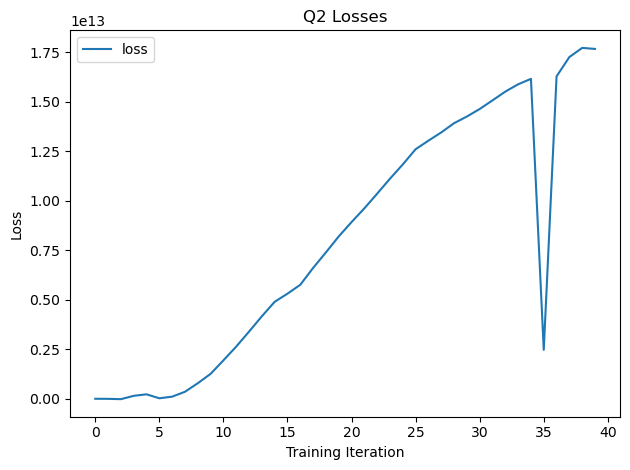

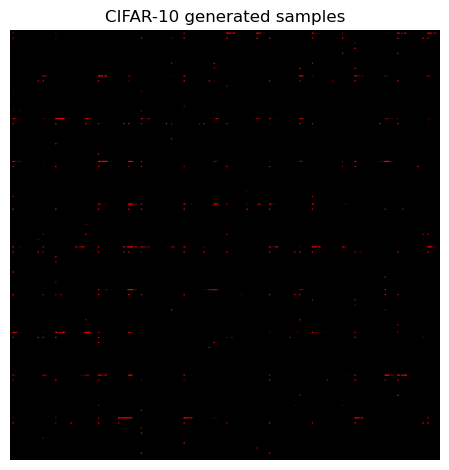

In [98]:
q2_save_results(q2)

## FID implementation

In [52]:
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'  # noqa: E501


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=(DEFAULT_BLOCK_INDEX,),
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(weights='DEFAULT')

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`"""
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    # Skips default weight inititialization if supported by torchvision
    # version. See https://github.com/mseitzer/pytorch-fid/issues/28.
    if version >= (0, 6):
        kwargs['init_weights'] = False

    # Backwards compatibility: `weights` argument was handled by `pretrained`
    # argument prior to version 0.13.
    if version < (0, 13) and 'weights' in kwargs:
        if kwargs['weights'] == 'DEFAULT':
            kwargs['pretrained'] = True
        elif kwargs['weights'] is None:
            kwargs['pretrained'] = False
        else:
            raise ValueError(
                'weights=={} not supported in torchvision {}'.format(
                    kwargs['weights'], torchvision.__version__
                )
            )
        del kwargs['weights']

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              weights=None)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [84]:
dataset = torchvision.datasets.CIFAR10("./data", transform=torchvision.transforms.ToTensor(),
                                          download=True, train=False)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=50,
                                         shuffle=False,
                                         drop_last=False,
                                         num_workers=num_workers)

batch = next(iter(dataloader))

Files already downloaded and verified


In [91]:
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import numpy as np
import torch
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--num-workers', type=int,
                    help=('Number of processes to use for data loading. '
                          'Defaults to `min(8, num_cpus)`'))
parser.add_argument('--device', type=str, default='cuda:0',
                    help='Device to use. Like cuda, cuda:0 or cpu')
parser.add_argument('--dims', type=int, default=192,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('--save-stats', action='store_true',
                    help=('Generate an npz archive from a directory of samples. '
                          'The first path is used as input and the second as output.'))
parser.add_argument('path', type=str, nargs='*', default=['./deepul/homeworks/hw4', './deepul/homeworks/hw4'],
                    help=('Paths to the generated images or '
                          'to .npz statistic files'))

IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


def get_activations(files, model, batch_size=8, dims=2048, device='cpu',
                    num_workers=1):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    # if batch_size > len(files):
    #     print(('Warning: batch size is bigger than the data size. '
    #            'Setting batch size to data size'))
    #     batch_size = len(files)

    # dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataset = torchvision.datasets.CIFAR10("./data", transform=torchvision.transforms.ToTensor(),
                                              download=True, train=False)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=num_workers)

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in tqdm(dataloader):
        batch, label = batch
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    if np.isnan(sigma1).any():
        print("There is any nan value in sigma1")
    if np.isinf(sigma1).any():
        print("There is any inf value in sigma1")
    if np.isnan(sigma2).any():
        print("There is any nan value in sigma2")
    if np.isinf(sigma2).any():
        print("There is any inf value in sigma2")

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50, dims=2048,
                                    device='cpu', num_workers=1):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, device, num_workers)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(path, model, batch_size, dims, device,
                               num_workers=1):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        path = pathlib.Path(path)
        files = sorted([file for ext in IMAGE_EXTENSIONS
                       for file in path.glob('*.{}'.format(ext))])
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, device, num_workers)

    return m, s


def calculate_fid_given_paths(paths, batch_size, device, dims, num_workers=1):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size,
                                        dims, device, num_workers)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def save_fid_stats(paths, batch_size, device, dims, num_workers=1):
    """Calculates the FID of two paths"""
    if not os.path.exists(paths[0]):
        raise RuntimeError('Invalid path: %s' % paths[0])

    if os.path.exists(paths[1]):
        raise RuntimeError('Existing output file: %s' % paths[1])

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    print(f"Saving statistics for {paths[0]}")

    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
                                        dims, device, num_workers)

    np.savez_compressed(paths[1], mu=m1, sigma=s1)

In [92]:
args = parser.parse_args([])
args.batch_size = 1

if args.device is None:
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
else:
    device = torch.device(args.device)

if args.num_workers is None:
    try:
        num_cpus = len(os.sched_getaffinity(0))
    except AttributeError:
        # os.sched_getaffinity is not available under Windows, use
        # os.cpu_count instead (which may not return the *available* number
        # of CPUs).
        num_cpus = os.cpu_count()

    num_workers = min(num_cpus, 8) if num_cpus is not None else 0
else:
    num_workers = args.num_workers

if args.save_stats:
    save_fid_stats(args.path, args.batch_size, device, args.dims, num_workers)

fid_value = calculate_fid_given_paths(args.path,
                                      args.batch_size,
                                      device,
                                      args.dims,
                                      num_workers)
print('FID: ', fid_value)

Files already downloaded and verified


100%|████████████████████████████████| 10000/10000 [00:13<00:00, 736.11it/s]


Files already downloaded and verified


100%|████████████████████████████████| 10000/10000 [00:12<00:00, 785.62it/s]

There is any nan value in sigma1.dot(sigma2):  True
There is any inf value in sigma1.dot(sigma2):  False
sigma1:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
sigma2:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


ValueError: array must not contain infs or NaNs

* Two dataset should be downloaded to the args.path to calculate FID.

# Question 3: Representation Learning with BiGAN on MNIST [45pt]

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


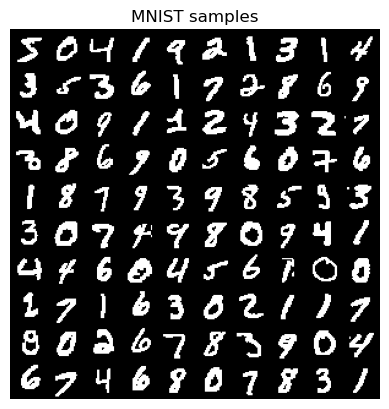

In [71]:
visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [11]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(g_input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.fc(x).reshape(x.shape[0], 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, z_dim, x_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim + x_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, z, x):
        x = torch.cat((z, x), dim=1)
        return self.fc(x)

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_dim),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.fc(x)

In [14]:
from torchvision.utils import save_image

class Solver(object):
    def __init__(self, train_data, test_data, n_epochs=100, batch_size=128, latent_dim=50):
        self.log_interval = 100
        self.batch_size = batch_size
        self.train_loader, self.test_loader = self.create_loaders(train_data, test_data)
        self.n_batches_in_epoch = len(self.train_loader)
        self.n_epochs = n_epochs
        self.curr_itr = 0
        self.latent_dim = latent_dim

    def build(self):
        # BiGAN 
        self.d = Discriminator(self.latent_dim, 784).to(ptu.device)
        self.e = Encoder(784, self.latent_dim).to(ptu.device) 
        self.g = Generator(self.latent_dim, 784).to(ptu.device)  
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        self.g_optimizer = torch.optim.Adam(list(self.e.parameters()) + list(self.g.parameters()), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
        self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        self.d_optimizer = torch.optim.Adam(self.d.parameters(), lr=2e-4, betas=(0, 0.9))
        self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(self.d_optimizer,
                                                             lambda epoch: (self.n_epochs - epoch) / self.n_epochs,
                                                             last_epoch=-1)
        
        # linear classifier 
        self.linear = nn.Linear(self.latent_dim, 10).to(device)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

    def reset_linear(self):
        self.linear = nn.Linear(self.latent_dim, 10).to(device)
        self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

    def create_loaders(self, train_data, test_data):
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        return train_loader, test_loader

    def get_discriminator_loss(self, x):
        z_fake = torch.normal(torch.zeros(x.shape[0], self.latent_dim), torch.ones(x.shape[0], self.latent_dim)).to(device)
        z_real = self.e(x).reshape(x.shape[0], self.latent_dim)
        x_fake = self.g(z_fake).reshape(x.shape[0], -1)
        x_real = x.view(x.shape[0], -1)

        d_loss = - 0.5 * (self.d(z_real, x_real)).log().mean() - 0.5 * (1 - self.d(z_fake, x_fake)).log().mean()
        return d_loss


    def train_bigan(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.d.train()
            self.g.train()
            self.e.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(self.train_loader):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(ptu.device).float()

                # do a minibatch update
                self.d_optimizer.zero_grad()
                d_loss = self.get_discriminator_loss(x)
                d_loss.backward()
                self.d_optimizer.step()

                # generator and encoder update
                self.g_optimizer.zero_grad()
                g_loss = -self.get_discriminator_loss(x)
                g_loss.backward()
                self.g_optimizer.step()

                self.batch_loss_history.append(d_loss.item())

            # step the learning rate
            self.g_scheduler.step()
            self.d_scheduler.step()
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)
            self.save_samples(100, f'epoch{epoch_i}_samples.png')

        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')
        train_losses = np.array(train_losses)

        return train_losses

    def train_linear_classifier(self):
        train_losses = []
        val_accs = []
        for epoch_i in range(self.n_epochs // 2):
            epoch_i += 1

            self.e.eval()
            self.linear.train()
            self.batch_loss_history = []

            for batch_i, (x, y) in enumerate(self.train_loader):
                batch_i += 1
                self.curr_itr += 1
                x = x.to(ptu.device).float() # * 2 - 1
                y = y.to(ptu.device)

                # calculate loss, take gradient step
                self.linear_optimizer.zero_grad()
                z = self.e(x).detach()
                pred = self.linear(z)
                linear_loss = F.cross_entropy(pred, y)
                linear_loss.backward()
                self.linear_optimizer.step()

                self.batch_loss_history.append(linear_loss.item())

            val_acc = self.val_acc()
            val_accs.append(val_acc)
            epoch_loss = np.mean(self.batch_loss_history)
            train_losses.append(epoch_loss)

        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')
        train_losses = np.array(train_losses)
        val_accs = np.array(val_accs)

        return train_losses, val_accs

    def sample(self, n):
        self.g.eval()
        with torch.no_grad():
            z = (torch.rand(n, self.latent_dim).to(device) - 0.5) * 2
            samples = self.g(z).reshape(-1, 1, 28, 28)
        return ptu.get_numpy(samples)

    def save_samples(self, n, filename):
        self.g.eval()
        with torch.no_grad():
            z = (torch.rand(n, self.latent_dim).to(device) - 0.5) * 2
            samples = self.g(z).reshape(-1, 1, 28, 28) * 0.5 + 1
            save_image(samples, filename, nrow=10, normalize=True)
    
    def get_reconstructions(self, x):
        self.g.eval()
        self.e.eval()
        with torch.no_grad():
            z = self.e(x)
            recons = self.g(z).reshape(-1, 1, 28, 28)
        return ptu.get_numpy(recons)

    def val_acc(self):
        self.e.eval()
        self.linear.eval()

        val_acc_total = 0
        val_items = 0
        with torch.no_grad():
            for (inputs, labels) in self.test_loader:
                inputs = inputs.to(device).float()
                z = self.e(inputs)
                labels = labels.to(device)
                logits = self.linear(z)
                predictions = torch.argmax(logits, dim=1)
                num_correct = torch.sum(predictions == labels).float()
                val_acc_total += num_correct
                val_items += inputs.shape[0]

        return ptu.get_numpy(val_acc_total / val_items)

    def save_models(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)
        torch.save(self.e.state_dict(), "e_" + filename)

    def load_models(self, filename):
        self.g.load_state_dict(torch.load("g_" + filename))
        self.d.load_state_dict(torch.load("d_" + filename))
        self.e.load_state_dict(torch.load("e_" + filename))

In [15]:
def q3(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    solver = Solver(train_data, test_data, n_epochs=100)
    solver.build()

    # get random encoder accuracy
    print("Training linear classifier on random encoder")
    train_losses, val_accs = solver.train_linear_classifier()

    # train bigan
    print("Training BiGAN")
    bigan_losses = solver.train_bigan()
    samples = solver.sample(100).transpose(0, 2, 3, 1) * 0.5 + 0.5
    train_images = train_data.data[:20].reshape(20, 1, 28, 28) / 255.0
    train_img_tensor = ptu.FloatTensor(train_images) * 2 - 1
    recons = solver.get_reconstructions(train_img_tensor) * 0.5 + 0.5

    # see benefit of unsupervised learning
    solver.reset_linear()
    print("Training linear classifier on BiGAN encoder")
    bigan_train_losses, bigan_val_accs = solver.train_linear_classifier()

    print(f"Final BiGAN test linear accuracy: {bigan_val_accs[-1]}")
    print(f"Final random encoder test linear accuracy: {val_accs[-1]}")

    return bigan_losses, samples, np.concatenate([train_images, recons], axis=0).transpose(0, 2, 3, 1), bigan_train_losses, train_losses

## Results

Training linear classifier on random encoder
Training BiGAN
Training linear classifier on BiGAN encoder
Final BiGAN test linear accuracy: 0.8463000059127808
Final random encoder test linear accuracy: 0.8053999543190002


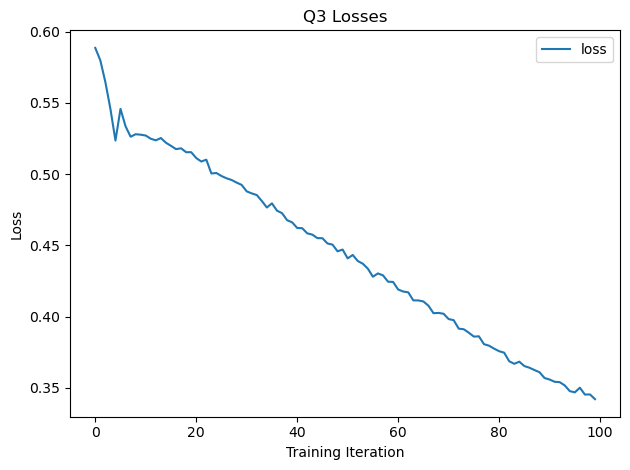

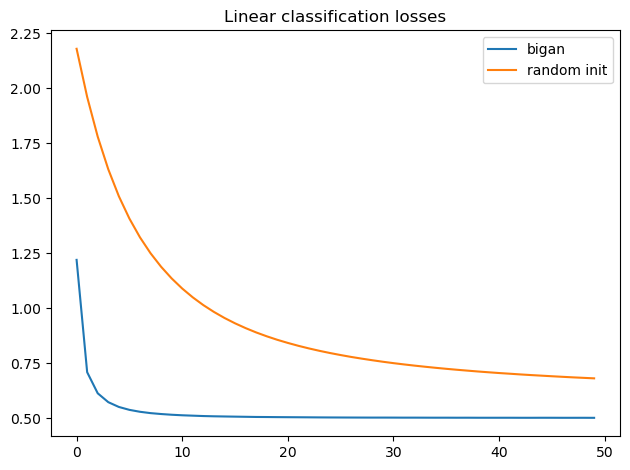

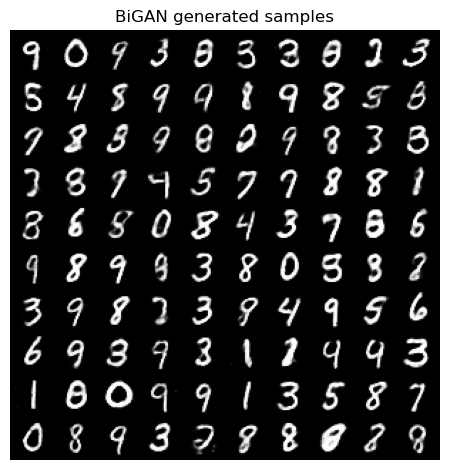

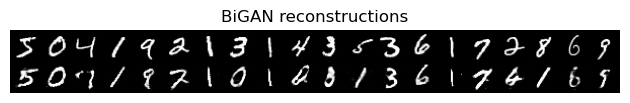

BiGAN final linear classification loss: 0.501085447286492
Random encoder linear classification loss: 0.6807139459322257


In [16]:
q3_save_results(q3)

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

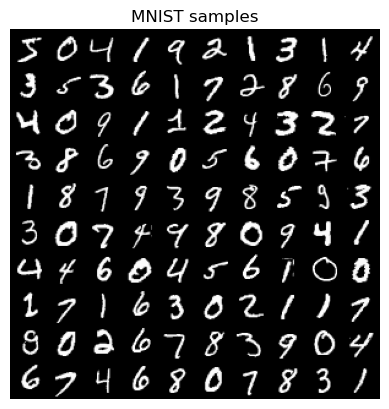

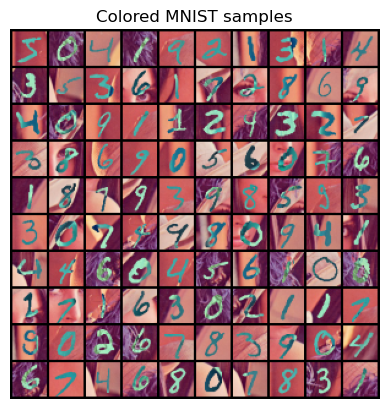

In [6]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [12]:
os.chdir("./CycleGAN")
os.getcwd()

'/root/dev/gen_assignment/DeepGenerativeModels/CycleGAN'

In [49]:
import argparse
from util import util
import models
import data

class BaseOptions():
    """This class defines options used during both training and test time.

    It also implements several helper functions such as parsing, printing, and saving the options.
    It also gathers additional options defined in <modify_commandline_options> functions in both dataset class and model class.
    """

    def __init__(self):
        """Reset the class; indicates the class hasn't been initailized"""
        self.initialized = False

    def initialize(self, parser):
        """Define the common options that are used in both training and test."""
        # basic parameters
        parser.add_argument('--dataroot', default = '.', help='path to images (should have subfolders trainA, trainB, valA, valB, etc)')
        parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
        parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
        # model parameters
        parser.add_argument('--model', type=str, default='cycle_gan', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
        parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
        parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
        parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
        parser.add_argument('--netG', type=str, default='resnet_9blocks', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
        parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
        parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
        parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
        parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
        parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
        # dataset parameters
        parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
        parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
        parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
        parser.add_argument('--num_threads', default=4, type=int, help='# threads for loading data')
        parser.add_argument('--batch_size', type=int, default=512, help='input batch size')
        parser.add_argument('--load_size', type=int, default=286, help='scale images to this size')
        parser.add_argument('--crop_size', type=int, default=256, help='then crop to this size')
        parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
        parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
        parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
        parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
        # additional parameters
        parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
        parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
        parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')
        # wandb parameters
        parser.add_argument('--use_wandb', action='store_true', help='if specified, then init wandb logging')
        parser.add_argument('--wandb_project_name', type=str, default='CycleGAN-and-pix2pix', help='specify wandb project name')
        self.initialized = True
        return parser

    def gather_options(self):
        """Initialize our parser with basic options(only once).
        Add additional model-specific and dataset-specific options.
        These options are defined in the <modify_commandline_options> function
        in model and dataset classes.
        """
        if not self.initialized:  # check if it has been initialized
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)

        # get the basic options
        opt, _ = parser.parse_known_args()

        # modify model-related parser options
        model_name = opt.model
        model_option_setter = models.get_option_setter(model_name)
        parser = model_option_setter(parser, self.isTrain)
        opt, _ = parser.parse_known_args()  # parse again with new defaults

        # modify dataset-related parser options
        dataset_name = opt.dataset_mode
        dataset_option_setter = data.get_option_setter(dataset_name)
        parser = dataset_option_setter(parser, self.isTrain)
        
        # arguments for cycleGAN experiment (in Jupyter)
        parser.dataroot = '.'
        parser.name = 'exp_cyclegan_230520'
        parser.model = 'cycle_gan'

        # save and return the parser
        self.parser = parser
        return parser.parse_args([]) # for jupyter

    def print_options(self, opt):
        """Print and save options

        It will print both current options and default values(if different).
        It will save options into a text file / [checkpoints_dir] / opt.txt
        """
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

        # save to the disk
        expr_dir = os.path.join(opt.checkpoints_dir, opt.name)
        util.mkdirs(expr_dir)
        file_name = os.path.join(expr_dir, '{}_opt.txt'.format(opt.phase))
        with open(file_name, 'wt') as opt_file:
            opt_file.write(message)
            opt_file.write('\n')

    def parse(self):
        """Parse our options, create checkpoints directory suffix, and set up gpu device."""
        opt = self.gather_options()
        opt.isTrain = self.isTrain   # train or test

        # process opt.suffix
        if opt.suffix:
            suffix = ('_' + opt.suffix.format(**vars(opt))) if opt.suffix != '' else ''
            opt.name = opt.name + suffix

        self.print_options(opt)

        # set gpu ids
        str_ids = opt.gpu_ids.split(',')
        opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                opt.gpu_ids.append(id)
        if len(opt.gpu_ids) > 0:
            torch.cuda.set_device(opt.gpu_ids[0])

        self.opt = opt
        return self.opt

class TrainOptions(BaseOptions):
    """This class includes training options.

    It also includes shared options defined in BaseOptions.
    """

    def initialize(self, parser):
        parser = BaseOptions.initialize(self, parser)
        # visdom and HTML visualization parameters
        parser.add_argument('--display_freq', type=int, default=400, help='frequency of showing training results on screen')
        parser.add_argument('--display_ncols', type=int, default=4, help='if positive, display all images in a single visdom web panel with certain number of images per row.')
        parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
        parser.add_argument('--display_server', type=str, default="http://localhost", help='visdom server of the web display')
        parser.add_argument('--display_env', type=str, default='main', help='visdom display environment name (default is "main")')
        parser.add_argument('--display_port', type=int, default=8097, help='visdom port of the web display')
        parser.add_argument('--update_html_freq', type=int, default=1000, help='frequency of saving training results to html')
        parser.add_argument('--print_freq', type=int, default=30000, help='frequency of showing training results on console')
        parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
        # network saving and loading parameters
        parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
        parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
        parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
        parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
        parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
        # training parameters
        parser.add_argument('--n_epochs', type=int, default=30, help='number of epochs with the initial learning rate')
        parser.add_argument('--n_epochs_decay', type=int, default=20, help='number of epochs to linearly decay learning rate to zero')
        parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
        parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
        parser.add_argument('--gan_mode', type=str, default='lsgan', help='the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.')
        parser.add_argument('--pool_size', type=int, default=50, help='the size of image buffer that stores previously generated images')
        parser.add_argument('--lr_policy', type=str, default='linear', help='learning rate policy. [linear | step | plateau | cosine]')
        parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')

        self.isTrain = True
        return parser

In [50]:
def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'for_mnist':
        net = UnetGenerator(input_nc, output_nc, 4, ngf, norm_layer=norm_laye,r use_dropout=use_dropout)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)

class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


# useful classes that can be used later!
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [51]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler


###############################################################################
# Helper Functions
###############################################################################


class Identity(nn.Module):
    def forward(self, x):
        return x


def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x):
            return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler

    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine

    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028

    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( ||gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss

    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)

In [52]:
from collections import OrderedDict
from abc import ABC, abstractmethod
import torch
import itertools
from util.image_pool import ImagePool
from models import networks

class BaseModel(ABC):
    """This class is an abstract base class (ABC) for models.
    To create a subclass, you need to implement the following five functions:
        -- <__init__>:                      initialize the class; first call BaseModel.__init__(self, opt).
        -- <set_input>:                     unpack data from dataset and apply preprocessing.
        -- <forward>:                       produce intermediate results.
        -- <optimize_parameters>:           calculate losses, gradients, and update network weights.
        -- <modify_commandline_options>:    (optionally) add model-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the BaseModel class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions

        When creating your custom class, you need to implement your own initialization.
        In this function, you should first call <BaseModel.__init__(self, opt)>
        Then, you need to define four lists:
            -- self.loss_names (str list):          specify the training losses that you want to plot and save.
            -- self.model_names (str list):         define networks used in our training.
            -- self.visual_names (str list):        specify the images that you want to display and save.
            -- self.optimizers (optimizer list):    define and initialize optimizers. You can define one optimizer for each network. If two networks are updated at the same time, you can use itertools.chain to group them. See cycle_gan_model.py for an example.
        """
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')  # get device name: CPU or GPU
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)  # save all the checkpoints to save_dir
        if opt.preprocess != 'scale_width':  # with [scale_width], input images might have different sizes, which hurts the performance of cudnn.benchmark.
            torch.backends.cudnn.benchmark = True
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0  # used for learning rate policy 'plateau'

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new model-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): includes the data itself and its metadata information.
        """
        pass

    @abstractmethod
    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        pass

    @abstractmethod
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        pass

    def setup(self, opt):
        """Load and print networks; create schedulers

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        if self.isTrain:
            self.schedulers = [networks.get_scheduler(optimizer, opt) for optimizer in self.optimizers]
        if not self.isTrain or opt.continue_train:
            load_suffix = 'iter_%d' % opt.load_iter if opt.load_iter > 0 else opt.epoch
            self.load_networks(load_suffix)
        self.print_networks(opt.verbose)

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    def test(self):
        """Forward function used in test time.

        This function wraps <forward> function in no_grad() so we don't save intermediate steps for backprop
        It also calls <compute_visuals> to produce additional visualization results
        """
        with torch.no_grad():
            self.forward()
            self.compute_visuals()

    def compute_visuals(self):
        """Calculate additional output images for visdom and HTML visualization"""
        pass

    def get_image_paths(self):
        """ Return image paths that are used to load current data"""
        return " "

    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            if self.opt.lr_policy == 'plateau':
                scheduler.step(self.metric)
            else:
                scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

    def get_current_visuals(self):
        """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        """Save all the networks to the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def load_networks(self, epoch):
        """Load all the networks from the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    def print_networks(self, verbose):
        """Print the total number of parameters in the network and (if verbose) network architecture

        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

class CycleGANModel(BaseModel):
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.

        For CycleGAN, in addition to GAN losses, we introduce lambda_A, lambda_B, and lambda_identity for the following losses.
        A (source domain), B (target domain).
        Generators: G_A: A -> B; G_B: B -> A.
        Discriminators: D_A: G_A(A) vs. B; D_B: G_B(B) vs. A.
        Forward cycle loss:  lambda_A * ||G_B(G_A(A)) - A|| (Eqn. (2) in the paper)
        Backward cycle loss: lambda_B * ||G_A(G_B(B)) - B|| (Eqn. (2) in the paper)
        Identity loss (optional): lambda_identity * (||G_A(B) - B|| * lambda_B + ||G_B(A) - A|| * lambda_A) (Sec 5.2 "Photo generation from paintings" in the paper)
        Dropout is not used in the original CycleGAN paper.
        """
        parser.set_defaults(no_dropout=True)  # default CycleGAN did not use dropout
        if is_train:
            parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
            parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping. Setting lambda_identity other than 0 has an effect of scaling the weight of the identity mapping loss. For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1')

        return parser

    def __init__(self, opt):
        """Initialize the CycleGAN class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseModel.__init__(self, opt)
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        visual_names_A = ['real_A', 'fake_B', 'rec_A']
        visual_names_B = ['real_B', 'fake_A', 'rec_B']
        if self.isTrain and self.opt.lambda_identity > 0.0:  # if identity loss is used, we also visualize idt_B=G_A(B) ad idt_A=G_A(B)
            visual_names_A.append('idt_B')
            visual_names_B.append('idt_A')

        self.visual_names = visual_names_A + visual_names_B  # combine visualizations for A and B
        # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>.
        if self.isTrain:
            self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        else:  # during test time, only load Gs
            self.model_names = ['G_A', 'G_B']

        # define networks (both Generators and discriminators)
        # The naming is different from those used in the paper.
        # Code (vs. paper): G_A (G), G_B (F), D_A (D_Y), D_B (D_X)
        self.netG_A = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)
        self.netG_B = networks.define_G(opt.output_nc, opt.input_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:  # define discriminators
            self.netD_A = networks.define_D(opt.output_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            self.netD_B = networks.define_D(opt.input_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            if opt.lambda_identity > 0.0:  # only works when input and output images have the same number of channels
                assert(opt.input_nc == opt.output_nc)
            self.fake_A_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
            self.fake_B_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
            # define loss functions
            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)  # define GAN loss.
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap domain A and domain B.
        """
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = input['A'].to(self.device).float()
        self.real_B = input['B'].to(self.device).float()

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
        self.fake_A = self.netG_B(self.real_B)  # G_B(B)
        self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def backward_D_basic(self, netD, real, fake):
        """Calculate GAN loss for the discriminator

        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator

        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights

In [53]:
def get_colored_mnist(data):
    # from https://www.wouterbulten.nl/blog/tech/getting-started-with-gans-2-colorful-mnist/
    # Read Lena image
    lena = PILImage.open('../deepul/hw4_utils/lena.jpg')

    # Resize
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (2.3, 2.3, 1), order=1) for image in data])

    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)

    # Make binary
    batch_binary = (batch_rgb > 0.5)

    batch = np.zeros((data.shape[0], 28, 28, 3))

    for i in range(data.shape[0]):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 64)
        y_c = np.random.randint(0, lena.size[1] - 64)
        image = lena.crop((x_c, y_c, x_c + 64, y_c + 64))
        image = np.asarray(image) / 255.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]

        batch[i] = cv2.resize(image, (0, 0), fx=28 / 64, fy=28 / 64, interpolation=cv2.INTER_AREA)
    return batch.transpose(0, 3, 1, 2)

def load_q4_data():
    train, _ = load_q3_data()
    mnist = np.array(train.data.reshape(-1, 28, 28, 1) / 255.0)
    colored_mnist = get_colored_mnist(mnist)
    return mnist.transpose(0, 3, 1, 2), colored_mnist

def visualize_cyclegan_datasets():
    mnist, colored_mnist = load_q4_data()
    mnist, colored_mnist = mnist[:100], colored_mnist[:100]
    show_samples(mnist.reshape([100, 28, 28, 1]) * 255.0, title=f'MNIST samples')
    show_samples(colored_mnist.transpose([0, 2, 3, 1]) * 255.0, title=f'Colored MNIST samples')

def q4_save_results(fn):
    mnist, cmnist = load_q4_data()

    m1, c1, m2, c2, m3, c3 = fn(mnist, cmnist)
    m1, m2, m3 = m1.repeat(3, axis=3), m2.repeat(3, axis=3), m3.repeat(3, axis=3)
    mnist_reconstructions = np.concatenate([m1, c1, m2], axis=0)
    colored_mnist_reconstructions = np.concatenate([c2, m3, c3], axis=0)

    show_samples(mnist_reconstructions * 255.0, nrow=20,
                 fname='figures/q4_mnist.png',
                 title=f'Source domain: MNIST')
    show_samples(colored_mnist_reconstructions * 255.0, nrow=20,
                 fname='figures/q4_colored_mnist.png',
                 title=f'Source domain: Colored MNIST')
    pass

In [54]:

from torch.utils.data import Dataset

class ConcatenatedDataset(Dataset):
    def __init__(self, opt, key_A, dataset_A, key_B, dataset_B):
        self.opt = opt
        
        self.dataset_A = dataset_A
        self.dataset_B = dataset_B
        self.key_A = key_A
        self.key_B = key_B
    
    def __getitem__(self, idx):
        data_A = self.dataset_A[idx]
        data_B = self.dataset_B[idx]
        
        return {self.key_A: data_A, self.key_B: data_B}
    
    def __len__(self):
        return min(len(self.dataset_A), len(self.dataset_B), self.opt.max_dataset_size)

In [67]:
import time
from torch.utils.data import DataLoader

def q4():
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """
    opt = TrainOptions().parse()
    
    model = CycleGANModel(opt) # create CycleGANModel with opt
    model.setup(opt)
    print("model [%s] was created" % type(model).__name__)
    total_iters = 0
    
    mnist, cmnist = load_q4_data()
    mnist_rgb = mnist.repeat(3,1)
    concat_dataset = ConcatenatedDataset(opt, 'A', mnist_rgb, 'B', cmnist)
    dataloader = torch.utils.data.DataLoader(
                concat_dataset,
                batch_size=opt.batch_size,
                shuffle=not opt.serial_batches,
                num_workers=int(opt.num_threads))
    
    print('The number of training images = {}, {}'.format(len(mnist), len(cmnist)))
    
    for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
        epoch_start_time = time.time()
        iter_data_time = time.time()
        epoch_iter = 0
        model.update_learning_rate()
        
        epoch_losses = OrderedDict()
        for name in model.loss_names:
            if isinstance(name, str):
                epoch_losses[name] = 0
        
        for i, data in enumerate(dataloader):
            iter_start_time = time.time()
            if total_iters % opt.print_freq == 0:
                t_data = iter_start_time - iter_data_time
            
            total_iters += opt.batch_size
            epoch_iter += opt.batch_size
            model.set_input(data)
            model.optimize_parameters()
            
#             if total_iters % opt.print_freq == 0:
#                 losses = model.get_current_losses()
#                 t_comp = (time.time() - iter_start_time) / opt.batch_size
#                 log = "epoch: {}, iters: {} time: {:3f}, data: {:3f}".format(epoch, total_iters, t_comp, t_data)
#                 for k, v in losses.items():
#                     epoch_losses[k] += v / opt.batch_size
#                     log += "{}: {:3f}".format(k, v)
                
            losses = model.get_current_losses()
            for k, v in losses.items():
                epoch_losses[k] += v / opt.batch_size
            
            iter_data_time = time.time()

        log = "End of epoch {} / {} \t Time taken: {} sec".format(epoch, opt.n_epochs + opt.n_epochs_decay,
                                                                  time.time() - epoch_start_time)
        for k, v in epoch_losses.items():
            log += "{}: {:3f} \t".format(k, v)
        
        print(log)
        
        if epoch == opt.n_epochs + opt.n_epochs_decay:
            sample = model.get_current_visuals()

            for key in sample.keys():
                # print(key)
                # print(sample[key].shape) # (1, 3, 28, 28)
                if key == "rec_A" or "fake_A":
                    plt.figure()
                    plt.title('Samples of {}'.format(key))
                    plt.imshow(sample[key][0].permute(1, 2, 0).detach().cpu().numpy(),
                              cmap=plt.get_cmap('gray')) # permute to (28, 28, 1)
                else:
                    plt.figure()
                    plt.title('Samples of {}'.format(key))
                    plt.imshow(sample[key][0].permute(1, 2, 0).detach().cpu().numpy()) # permute to (28, 28, 3)
                

## Results

----------------- Options ---------------
               batch_size: 512                           
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: .                             
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


End of epoch 50 / 50 	 Time taken: 73.60151314735413 secD_A: 0.048317 	G_A: 0.073898 	cycle_A: 0.048130 	idt_A: 0.045422 	D_B: 0.002721 	G_B: 0.214818 	cycle_B: 0.115504 	idt_B: 0.019616 	


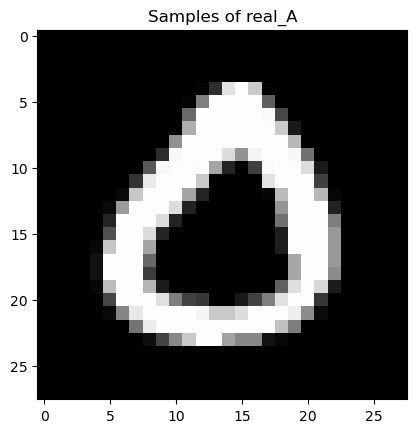

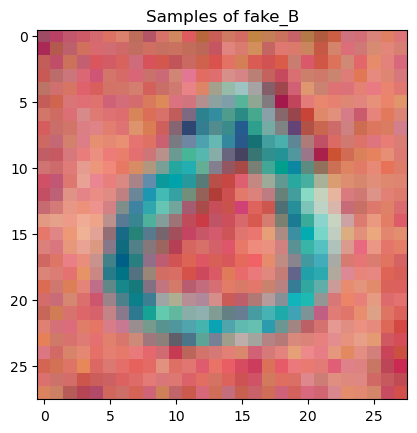

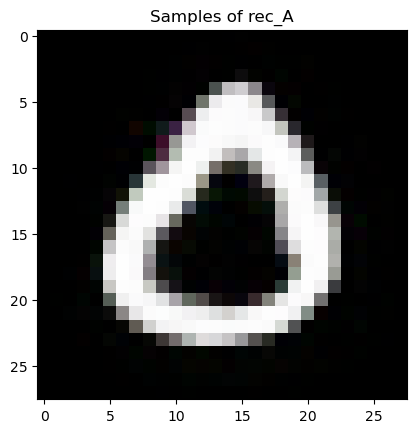

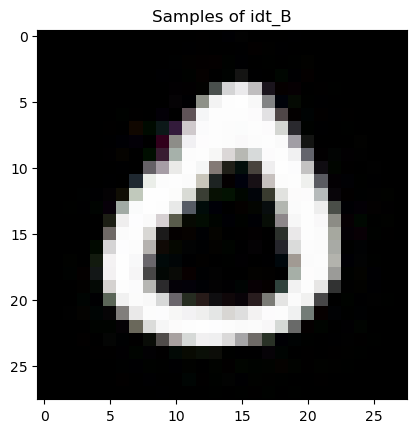

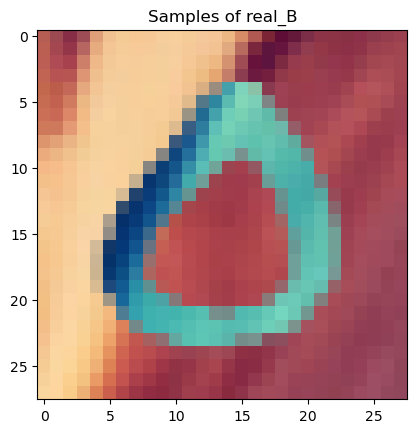

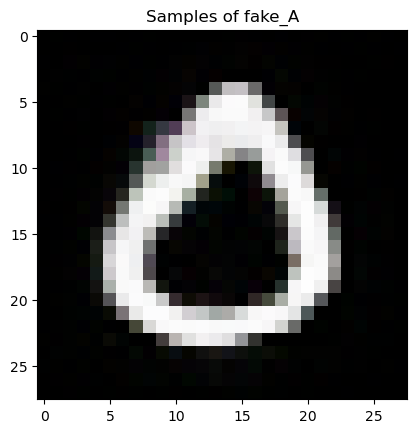

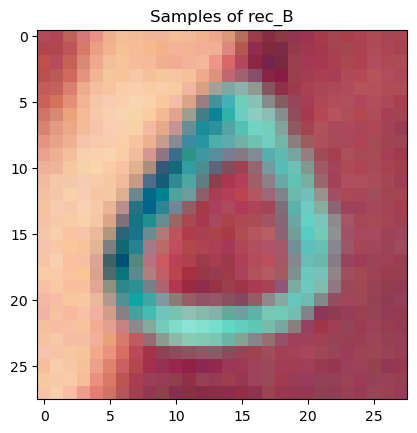

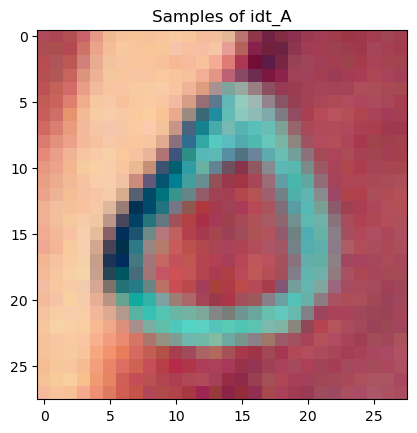

In [68]:
q4()

# Added Feature : pix2pix

In [34]:
import argparse
import models
from util import util
import data
import time
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from collections import OrderedDict
from abc import ABC, abstractmethod
import torch
import itertools
from util.image_pool import ImagePool

class BaseOptions():
    """This class defines options used during both training and test time.

    It also implements several helper functions such as parsing, printing, and saving the options.
    It also gathers additional options defined in <modify_commandline_options> functions in both dataset class and model class.
    """

    def __init__(self):
        """Reset the class; indicates the class hasn't been initailized"""
        self.initialized = False

    def initialize(self, parser):
        """Define the common options that are used in both training and test."""
        # basic parameters
        parser.add_argument('--dataroot', default = '.', help='path to images (should have subfolders trainA, trainB, valA, valB, etc)')
        parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
        parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
        # model parameters
        parser.add_argument('--model', type=str, default='pix2pix', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
        parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
        parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
        parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
        parser.add_argument('--netG', type=str, default='unet_256', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
        parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
        parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
        parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
        parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
        parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
        # dataset parameters
        parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
        parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
        parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
        parser.add_argument('--num_threads', default=4, type=int, help='# threads for loading data')
        parser.add_argument('--batch_size', type=int, default=512, help='input batch size')
        parser.add_argument('--load_size', type=int, default=128, help='scale images to this size')
        parser.add_argument('--crop_size', type=int, default=128, help='then crop to this size')
        parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
        parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
        parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
        parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
        # additional parameters
        parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
        parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
        parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')
        # wandb parameters
        parser.add_argument('--use_wandb', action='store_true', help='if specified, then init wandb logging')
        parser.add_argument('--wandb_project_name', type=str, default='CycleGAN-and-pix2pix', help='specify wandb project name')
        self.initialized = True
        return parser

    def gather_options(self):
        """Initialize our parser with basic options(only once).
        Add additional model-specific and dataset-specific options.
        These options are defined in the <modify_commandline_options> function
        in model and dataset classes.
        """
        if not self.initialized:  # check if it has been initialized
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)

        # get the basic options
        opt, _ = parser.parse_known_args()

        # modify model-related parser options
        model_name = opt.model
        model_option_setter = models.get_option_setter(model_name)
        parser = model_option_setter(parser, self.isTrain)
        opt, _ = parser.parse_known_args()  # parse again with new defaults

        # modify dataset-related parser options
        dataset_name = opt.dataset_mode
        dataset_option_setter = data.get_option_setter(dataset_name)
        parser = dataset_option_setter(parser, self.isTrain)
        
        # arguments for cycleGAN experiment (in Jupyter)
        parser.dataroot = '.'
        parser.name = 'exp_cyclegan_230520'
        parser.model = 'cycle_gan'

        # save and return the parser
        self.parser = parser
        return parser.parse_args([]) # for jupyter

    def print_options(self, opt):
        """Print and save options

        It will print both current options and default values(if different).
        It will save options into a text file / [checkpoints_dir] / opt.txt
        """
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

        # save to the disk
        expr_dir = os.path.join(opt.checkpoints_dir, opt.name)
        util.mkdirs(expr_dir)
        file_name = os.path.join(expr_dir, '{}_opt.txt'.format(opt.phase))
        with open(file_name, 'wt') as opt_file:
            opt_file.write(message)
            opt_file.write('\n')

    def parse(self):
        """Parse our options, create checkpoints directory suffix, and set up gpu device."""
        opt = self.gather_options()
        opt.isTrain = self.isTrain   # train or test

        # process opt.suffix
        if opt.suffix:
            suffix = ('_' + opt.suffix.format(**vars(opt))) if opt.suffix != '' else ''
            opt.name = opt.name + suffix

        self.print_options(opt)

        # set gpu ids
        str_ids = opt.gpu_ids.split(',')
        opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                opt.gpu_ids.append(id)
        if len(opt.gpu_ids) > 0:
            torch.cuda.set_device(opt.gpu_ids[0])

        self.opt = opt
        return self.opt

class TrainOptions(BaseOptions):
    """This class includes training options.

    It also includes shared options defined in BaseOptions.
    """

    def initialize(self, parser):
        parser = BaseOptions.initialize(self, parser)
        # visdom and HTML visualization parameters
        parser.add_argument('--display_freq', type=int, default=400, help='frequency of showing training results on screen')
        parser.add_argument('--display_ncols', type=int, default=4, help='if positive, display all images in a single visdom web panel with certain number of images per row.')
        parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
        parser.add_argument('--display_server', type=str, default="http://localhost", help='visdom server of the web display')
        parser.add_argument('--display_env', type=str, default='main', help='visdom display environment name (default is "main")')
        parser.add_argument('--display_port', type=int, default=8097, help='visdom port of the web display')
        parser.add_argument('--update_html_freq', type=int, default=1000, help='frequency of saving training results to html')
        parser.add_argument('--print_freq', type=int, default=30000, help='frequency of showing training results on console')
        parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
        # network saving and loading parameters
        parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
        parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
        parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
        parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
        parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
        # training parameters
        parser.add_argument('--n_epochs', type=int, default=30, help='number of epochs with the initial learning rate')
        parser.add_argument('--n_epochs_decay', type=int, default=20, help='number of epochs to linearly decay learning rate to zero')
        parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
        parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
        parser.add_argument('--gan_mode', type=str, default='lsgan', help='the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.')
        parser.add_argument('--pool_size', type=int, default=50, help='the size of image buffer that stores previously generated images')
        parser.add_argument('--lr_policy', type=str, default='linear', help='learning rate policy. [linear | step | plateau | cosine]')
        parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')

        self.isTrain = True
        return parser

In [35]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler


###############################################################################
# Helper Functions
###############################################################################


class Identity(nn.Module):
    def forward(self, x):
        return x


def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x):
            return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler

    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine

    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'for_mnist':
        net = UnetGenerator(input_nc, output_nc, 4, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028

    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( ||gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss

    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        print("UnetGenerator initialized!!!!")
        count = 0
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)

In [36]:
from collections import OrderedDict
from abc import ABC, abstractmethod
import torch
import itertools
from util.image_pool import ImagePool

class BaseModel(ABC):
    """This class is an abstract base class (ABC) for models.
    To create a subclass, you need to implement the following five functions:
        -- <__init__>:                      initialize the class; first call BaseModel.__init__(self, opt).
        -- <set_input>:                     unpack data from dataset and apply preprocessing.
        -- <forward>:                       produce intermediate results.
        -- <optimize_parameters>:           calculate losses, gradients, and update network weights.
        -- <modify_commandline_options>:    (optionally) add model-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the BaseModel class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions

        When creating your custom class, you need to implement your own initialization.
        In this function, you should first call <BaseModel.__init__(self, opt)>
        Then, you need to define four lists:
            -- self.loss_names (str list):          specify the training losses that you want to plot and save.
            -- self.model_names (str list):         define networks used in our training.
            -- self.visual_names (str list):        specify the images that you want to display and save.
            -- self.optimizers (optimizer list):    define and initialize optimizers. You can define one optimizer for each network. If two networks are updated at the same time, you can use itertools.chain to group them. See cycle_gan_model.py for an example.
        """
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')  # get device name: CPU or GPU
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)  # save all the checkpoints to save_dir
        if opt.preprocess != 'scale_width':  # with [scale_width], input images might have different sizes, which hurts the performance of cudnn.benchmark.
            torch.backends.cudnn.benchmark = True
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0  # used for learning rate policy 'plateau'

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new model-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): includes the data itself and its metadata information.
        """
        pass

    @abstractmethod
    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        pass

    @abstractmethod
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        pass

    def setup(self, opt):
        """Load and print networks; create schedulers

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        if self.isTrain:
            self.schedulers = [get_scheduler(optimizer, opt) for optimizer in self.optimizers]
        if not self.isTrain or opt.continue_train:
            load_suffix = 'iter_%d' % opt.load_iter if opt.load_iter > 0 else opt.epoch
            self.load_networks(load_suffix)
        self.print_networks(opt.verbose)

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    def test(self):
        """Forward function used in test time.

        This function wraps <forward> function in no_grad() so we don't save intermediate steps for backprop
        It also calls <compute_visuals> to produce additional visualization results
        """
        with torch.no_grad():
            self.forward()
            self.compute_visuals()

    def compute_visuals(self):
        """Calculate additional output images for visdom and HTML visualization"""
        pass

    def get_image_paths(self):
        """ Return image paths that are used to load current data"""
        return " "

    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        old_lr = self.optimizers[0].param_groups[0]['lr']
        for scheduler in self.schedulers:
            if self.opt.lr_policy == 'plateau':
                scheduler.step(self.metric)
            else:
                scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate %.7f -> %.7f' % (old_lr, lr))

    def get_current_visuals(self):
        """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        """Save all the networks to the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def load_networks(self, epoch):
        """Load all the networks from the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    def print_networks(self, verbose):
        """Print the total number of parameters in the network and (if verbose) network architecture

        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

class Pix2PixModel(BaseModel):
    """ This class implements the pix2pix model, for learning a mapping from input images to output images given paired data.

    The model training requires '--dataset_mode aligned' dataset.
    By default, it uses a '--netG unet256' U-Net generator,
    a '--netD basic' discriminator (PatchGAN),
    and a '--gan_mode' vanilla GAN loss (the cross-entropy objective used in the orignal GAN paper).

    pix2pix paper: https://arxiv.org/pdf/1611.07004.pdf
    """
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.

        For pix2pix, we do not use image buffer
        The training objective is: GAN Loss + lambda_L1 * ||G(A)-B||_1
        By default, we use vanilla GAN loss, UNet with batchnorm, and aligned datasets.
        """
        # changing the default values to match the pix2pix paper (https://phillipi.github.io/pix2pix/)
        parser.set_defaults(norm='batch', netG='unet_256', dataset_mode='aligned')
        if is_train:
            parser.set_defaults(pool_size=0, gan_mode='vanilla')
            parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')

        return parser

    def __init__(self, opt):
        """Initialize the pix2pix class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseModel.__init__(self, opt)
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['G_GAN', 'G_L1', 'D_real', 'D_fake']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        self.visual_names = ['real_A', 'fake_B', 'real_B']
        # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>
        if self.isTrain:
            self.model_names = ['G', 'D']
        else:  # during test time, only load G
            self.model_names = ['G']
        # define networks (both generator and discriminator)
        self.netG = define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                      not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:  # define a discriminator; conditional GANs need to take both input and output images; Therefore, #channels for D is input_nc + output_nc
            self.netD = define_D(opt.input_nc + opt.output_nc, opt.ndf, opt.netD,
                                          opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            # define loss functions
            self.criterionGAN = GANLoss(opt.gan_mode).to(self.device)
            self.criterionL1 = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap images in domain A and domain B.
        """
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = input['A'].to(self.device).float()
        self.real_B = input['B'].to(self.device).float()

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG(self.real_A)  # G(A)

    def backward_D(self):
        """Calculate GAN loss for the discriminator"""
        # Fake; stop backprop to the generator by detaching fake_B
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)  # we use conditional GANs; we need to feed both input and output to the discriminator
        pred_fake = self.netD(fake_AB.detach())
        self.loss_D_fake = self.criterionGAN(pred_fake, False)
        # Real
        real_AB = torch.cat((self.real_A, self.real_B), 1)
        pred_real = self.netD(real_AB)
        self.loss_D_real = self.criterionGAN(pred_real, True)
        # combine loss and calculate gradients
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        """Calculate GAN and L1 loss for the generator"""
        # First, G(A) should fake the discriminator
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)
        pred_fake = self.netD(fake_AB)
        self.loss_G_GAN = self.criterionGAN(pred_fake, True)
        # Second, G(A) = B
        self.loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.opt.lambda_L1
        # combine loss and calculate gradients
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()                   # compute fake images: G(A)
        # update D
        self.set_requires_grad(self.netD, True)  # enable backprop for D
        self.optimizer_D.zero_grad()     # set D's gradients to zero
        self.backward_D()                # calculate gradients for D
        self.optimizer_D.step()          # update D's weights
        # update G
        self.set_requires_grad(self.netD, False)  # D requires no gradients when optimizing G
        self.optimizer_G.zero_grad()        # set G's gradients to zero
        self.backward_G()                   # calculate graidents for G
        self.optimizer_G.step()             # update G's weights

In [37]:
def get_colored_mnist(data):
    # from https://www.wouterbulten.nl/blog/tech/getting-started-with-gans-2-colorful-mnist/
    # Read Lena image
    lena = PILImage.open('../deepul/hw4_utils/lena.jpg')

    # Resize
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (2.3, 2.3, 1), order=1) for image in data])

    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)

    # Make binary
    batch_binary = (batch_rgb > 0.5)

    batch = np.zeros((data.shape[0], 28, 28, 3))

    for i in range(data.shape[0]):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 64)
        y_c = np.random.randint(0, lena.size[1] - 64)
        image = lena.crop((x_c, y_c, x_c + 64, y_c + 64))
        image = np.asarray(image) / 255.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]

        batch[i] = cv2.resize(image, (0, 0), fx=28 / 64, fy=28 / 64, interpolation=cv2.INTER_AREA)
    return batch.transpose(0, 3, 1, 2)

def load_q4_data():
    train, _ = load_q3_data()
    mnist = np.array(train.data.reshape(-1, 28, 28, 1) / 255.0)
    colored_mnist = get_colored_mnist(mnist)
    return mnist.transpose(0, 3, 1, 2), colored_mnist

def visualize_cyclegan_datasets():
    mnist, colored_mnist = load_q4_data()
    mnist, colored_mnist = mnist[:100], colored_mnist[:100]
    show_samples(mnist.reshape([100, 28, 28, 1]) * 255.0, title=f'MNIST samples')
    show_samples(colored_mnist.transpose([0, 2, 3, 1]) * 255.0, title=f'Colored MNIST samples')

def q4_save_results(fn):
    mnist, cmnist = load_q4_data()

    m1, c1, m2, c2, m3, c3 = fn(mnist, cmnist)
    m1, m2, m3 = m1.repeat(3, axis=3), m2.repeat(3, axis=3), m3.repeat(3, axis=3)
    mnist_reconstructions = np.concatenate([m1, c1, m2], axis=0)
    colored_mnist_reconstructions = np.concatenate([c2, m3, c3], axis=0)

    show_samples(mnist_reconstructions * 255.0, nrow=20,
                 fname='figures/q4_mnist.png',
                 title=f'Source domain: MNIST')
    show_samples(colored_mnist_reconstructions * 255.0, nrow=20,
                 fname='figures/q4_colored_mnist.png',
                 title=f'Source domain: Colored MNIST')
    pass

In [38]:
from torch.utils.data import Dataset

class ConcatenatedDataset(Dataset):
    def __init__(self, opt, key_A, dataset_A, key_B, dataset_B):
        self.opt = opt
        
        self.dataset_A = dataset_A
        self.dataset_B = dataset_B
        self.key_A = key_A
        self.key_B = key_B
    
    def __getitem__(self, idx):
        data_A = self.dataset_A[idx]
        data_B = self.dataset_B[idx]
        
        return {self.key_A: data_A, self.key_B: data_B}
    
    def __len__(self):
        return min(len(self.dataset_A), len(self.dataset_B), self.opt.max_dataset_size)

In [41]:
import time
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

def q5():
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """
    opt = TrainOptions().parse()
    print("crop_size: ", opt.crop_size)
    print("default netG: ", opt.netG)
    opt.netG = 'resnet_6blocks'
    print("netG for mnist datasets: ", opt.netG)
    
    model = Pix2PixModel(opt) # create Pix2PixModel with opt
    model.setup(opt)
    print("model [%s] was created" % type(model).__name__)
    total_iters = 0
    
    mnist, cmnist = load_q4_data()
    print("shape of mnist: ", mnist.shape)
    print("shape of cmnist: ", cmnist.shape)
    mnist_rgb = mnist.repeat(3,1)
    
    concat_dataset = ConcatenatedDataset(opt, 'A', mnist_rgb, 'B', cmnist)
    dataloader = torch.utils.data.DataLoader(
                concat_dataset,
                batch_size=opt.batch_size,
                shuffle=not opt.serial_batches,
                num_workers=int(opt.num_threads))
    
    print('The number of training images = {}, {}'.format(len(mnist), len(cmnist)))
    
    for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
        epoch_start_time = time.time()
        iter_data_time = time.time()
        epoch_iter = 0
        model.update_learning_rate()
        
        epoch_losses = OrderedDict()
        for name in model.loss_names:
            if isinstance(name, str):
                epoch_losses[name] = 0
        
        for i, data in enumerate(dataloader):
            iter_start_time = time.time()
            if total_iters % opt.print_freq == 0:
                t_data = iter_start_time - iter_data_time
            
            total_iters += opt.batch_size
            epoch_iter += opt.batch_size
            model.set_input(data)
            model.optimize_parameters()
            
#             if total_iters % opt.print_freq == 0:
#                 losses = model.get_current_losses()
#                 t_comp = (time.time() - iter_start_time) / opt.batch_size
#                 log = "epoch: {}, iters: {} time: {:3f}, data: {:3f}".format(epoch, total_iters, t_comp, t_data)
#                 for k, v in losses.items():
#                     epoch_losses[k] += v / opt.batch_size
#                     log += "{}: {:3f}".format(k, v)
                
            losses = model.get_current_losses()
            for k, v in losses.items():
                epoch_losses[k] += v / opt.batch_size
            
            iter_data_time = time.time()

        log = "End of epoch {} / {} \t Time taken: {} sec".format(epoch, opt.n_epochs + opt.n_epochs_decay,
                                                                  time.time() - epoch_start_time)
        for k, v in epoch_losses.items():
            log += "{}: {:3f} \t".format(k, v)
        
        print(log)
        
        if epoch == opt.n_epochs + opt.n_epochs_decay:
            sample = model.get_current_visuals()

            for key in sample.keys():
                # print(key)
                # print(sample[key].shape) # (1, 3, 28, 28)
                if key == "real_A":
                    plt.figure()
                    plt.title('Samples of {}'.format(key))
                    plt.imshow(sample[key][0].permute(1, 2, 0).detach().cpu().numpy(),
                              cmap=plt.get_cmap('gray')) # permute to (28, 28, 1)
                else:
                    plt.figure()
                    plt.title('Samples of {}'.format(key))
                    plt.imshow(sample[key][0].permute(1, 2, 0).detach().cpu().numpy()) # permute to (28, 28, 3)
                

## Results

----------------- Options ---------------
               batch_size: 512                           
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 128                           
                 dataroot: .                             
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


End of epoch 50 / 50 	 Time taken: 10.093738079071045 secG_GAN: 0.631901 	G_L1: 4.447886 	D_real: 0.017207 	D_fake: 0.025272 	


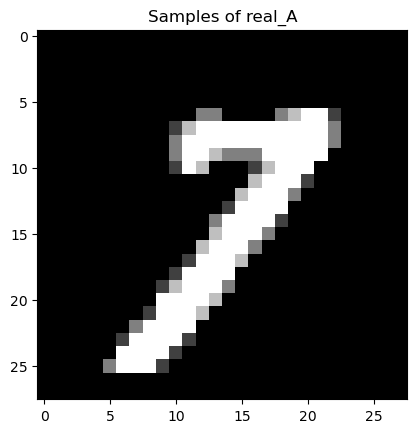

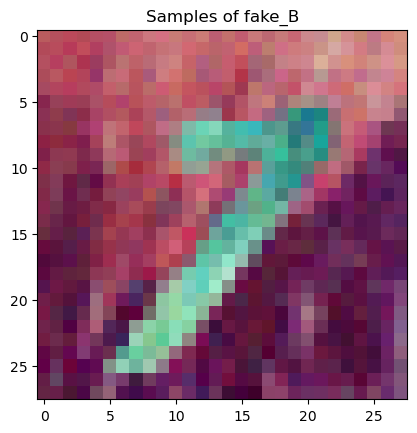

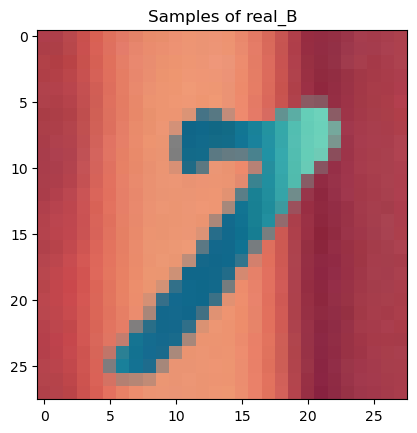

In [42]:
q5()